In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import norm

In [3]:
def generate_normal_series(number, mean):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        for l in range(length):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [4]:
number_normal = 1000
data_normal, labels_normal = generate_normal_series(number_normal, 0)

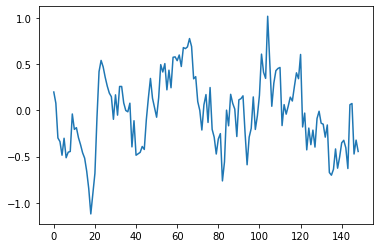

In [5]:
plt.plot(data_normal[0])

In [6]:
def generate_anomaly_series(number, mean_old, mean_new):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, length-20)
        for l in range(length):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [7]:
number_anomaly = 200
data_anomaly, labels_anomaly = generate_anomaly_series(number_anomaly, 0, 5)

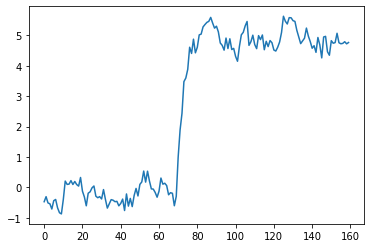

In [8]:
plt.plot(data_anomaly[0])

In [9]:
# def loss_delay_detection(p_slice):
#     length = len(p_slice)
#     loss = 0
#     for i in range(length):
#         loss += (i+1)*p_slice[i] * torch.prod((torch.ones(i).float()-p_slice[:i]))
#     return loss

def loss_delay_detection(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = torch.arange(1, n+1) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss

# def loss_delay_detection(p_slice):
#     n = p_slice.size(0)
#     prod = torch.ones(n)
# #     prod[1:] -= p_slice[:-1]
#     prod -= p_slice
#     cumprod = torch.cumprod(prod, dim=0)
#     loss = torch.arange(1, n+1) * cumprod
#     loss = torch.sum(loss)
#     return loss

# def loss_delay_detection(p_slice):
#     n = p_slice.size(0)
#     prod = torch.ones(n) - p_slice
#     loss = torch.arange(1, n+1) * prod
#     loss = torch.sum(loss)
#     return loss

# def loss_false_alarms_i(p_slice):
#     length = len(p_slice)
#     loss = 0
#     for i in range(length):
#         loss += p_slice[i] * torch.prod((torch.ones(i).float()-p_slice[:i]))
#     return loss

def loss_false_alarms_i(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = p_slice * cumprod
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice, l = 4):
    length = len(p_slice)
    loss = 0
    for i in range(0, l):
        ind = i*(length//l)
        loss += loss_false_alarms_i(p_slice[ind: ind + length//l])
    loss = torch.sum(loss)
    return loss

# def loss_false_alarms(p_slice):
#     loss = torch.sum(p_slice)
#     return loss

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(1)

In [112]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = 0
        l = 4
        w = 3
        n, m = labels.size()
#         delta = torch.abs(labels[:, 1:] - labels[:, :-1])
#         sample_indices, change_indices = torch.nonzero(delta > 1e-3, as_tuple=True)
        sample_indices, change_indices = torch.nonzero(labels[:, 1:] != labels[:, :-1], as_tuple=True)
        
        if (sample_indices[1:] != sample_indices[:-1]).all():
            false_alarm_mask = torch.ones(n, dtype=torch.bool)
            false_alarm_mask[sample_indices] = False
            false_alarm_mask_one = labels[false_alarm_mask, 0] == 1
            
            false_alarm_data = output[false_alarm_mask]
            false_alarm_one_data = false_alarm_data[false_alarm_mask_one]
            false_alarm_zero_data = false_alarm_data[~false_alarm_mask_one]
            
            # loss_delay_detection
            change_indices += 1
            arange = torch.arange(1, m+1, requires_grad=False)
            change_data = output[sample_indices]
            for change_data_i, n_i in zip(change_data, change_indices):
                new_w = min(w, m - n_i)
                p_slice = change_data_i[n_i:n_i + new_w]
                prod = torch.ones(new_w, requires_grad=False)
                prod[1:] -= p_slice[:-1]
                cumprod = torch.cumprod(prod, dim=0)
                loss += torch.sum(arange[:new_w] * p_slice * cumprod) + (new_w + 1)*torch.prod(prod[1:])*(1 - p_slice[-1])
#             print(loss)

            # loss_false_alarms_ones    
            prod = torch.ones_like(false_alarm_one_data, requires_grad=False)
            prod[:, 1:] -= false_alarm_one_data[:, :-1]
            cumprod = torch.cumprod(prod, dim=1)
            loss += torch.sum(false_alarm_one_data * cumprod)
#             print(loss)
            # loss_false_alarms_zeros
            step = m // l
            length = l * step
            false_alarm_zero_data = false_alarm_zero_data[:, :length].view(-1, l, step)
            
            prod = torch.ones_like(false_alarm_zero_data, requires_grad=False)
            prod[:, :, 1:] -= false_alarm_zero_data[:, :, :-1]
            cumprod = torch.cumprod(prod, dim=2)
            loss += torch.sum(false_alarm_zero_data * cumprod)
#             print(loss)
            loss /= n
#             print(loss)
        else:
            print("Error, indicate double change", sample_indices, change_indices)
            indices = torch.unique(sample_indices)
            print(labels[indices])
            print(labels[indices, 1:] != labels[indices, :-1])
            print(labels[:, 1:] != labels[:, :1])
            print(labels)
        
        return loss

In [111]:
# class CustomLoss(nn.Module):
    
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.counter_one = 0
#         self.counter_zero = 0
        
#     def forward(self, outputs, labels):
#         loss = torch.empty(labels.size(0))
#         for i, label in enumerate(labels):
#             ind = torch.nonzero(label[1:] != label[:1]) 
#             if ind.size()[0] == 0:
#                 if label[0] == 0:
#                     loss[i] = loss_false_alarms(outputs[i, :])
#                     self.counter_zero += 1
#                 else:
#                     #loss[i] = loss_false_alarms(torch.ones(len(outputs)).float() - outputs[i, :])     
#                     loss[i] = loss_delay_detection(outputs[i, :])
#                     self.counter_one += 1
#             else:
#                 loss[i] = loss_delay_detection(outputs[i, ind[0]:])
#         loss = torch.mean(loss)
#         return loss

In [52]:
all_ts_data = np.asarray(data_normal + data_anomaly)
all_labels = np.asarray(labels_normal + labels_anomaly)

In [53]:
from sklearn.model_selection import train_test_split

In [20]:
ts_train, ts_test, label_train, label_test = train_test_split(all_ts_data, all_labels, 
                                                              test_size=0.25, shuffle=True,
                                                              random_state=42)

In [21]:
def create_sequences(ts, label, tw):
    inout_seq = []
    for t in range(len(ts)):
        curr_ts = torch.FloatTensor(ts[t]).view(-1)
        curr_label = torch.IntTensor(label[t]).view(-1)
        for i in range(len(curr_ts) - tw):
            train_seq = curr_ts[i:i+tw]
            train_label = curr_label[i:i+tw]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [22]:
train_inout_seq = create_sequences(ts_train, label_train, 32)
val_inout_seq = create_sequences(ts_test, label_test, 32)

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.activation = nn.Sigmoid()
        
    #    self.reset_parameters()

    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq[:, None, :], hidden)        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)        

        out = self.dropout(lstm_out)
        out = self.linear(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
    
    #def reset_parameters(self):
    #    init_range = 0.025
    #    for param in self.parameters():
    #        param.data.uniform(-init_range, init_range)

In [24]:
train_inout_seq = train_inout_seq[:-(len(train_inout_seq)%32)]
val_inout_seq = val_inout_seq[:-(len(val_inout_seq)%32)]

In [91]:
model = LSTM(input_size=32, output_size=32, hidden_dim=2, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = CustomLoss()

In [26]:
device = torch.device("cpu")

In [27]:
len(train_inout_seq)

83264

In [28]:
from tqdm.notebook import tqdm

In [29]:
train_loader = DataLoader(train_inout_seq, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_inout_seq, batch_size=32, shuffle=True, num_workers=1)

In [105]:
epochs = 2
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

output_size = 32
hidden_dim = 2
n_layers = 2
batch_size=32

loss_list = []
acc_list = []
counter = 0
model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in tqdm(train_loader):
        
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)        
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if counter%print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_out, val_h = model(val_inputs, val_h)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)
                #plt.figure(figsize=(20, 12))
                #plt.plot(val_outputs_one)
                #plt.show()
                #plt.plot(val_outputs_one[0])
                #plt.show()
                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

Epoch: 1/2... Step: 500... Loss: 1.179465... Val Loss: 1.176526
Epoch: 1/2... Step: 1000... Loss: 1.232222... Val Loss: 1.147185
Epoch: 1/2... Step: 1500... Loss: 1.047923... Val Loss: 1.142097
Epoch: 1/2... Step: 2000... Loss: 1.047676... Val Loss: 1.142140
Epoch: 1/2... Step: 2500... Loss: 1.032305... Val Loss: 1.129941



Epoch: 2/2... Step: 3000... Loss: 1.017370... Val Loss: 1.115502
Epoch: 2/2... Step: 3500... Loss: 1.106566... Val Loss: 1.109838
Epoch: 2/2... Step: 4000... Loss: 1.012412... Val Loss: 1.109660
Epoch: 2/2... Step: 4500... Loss: 1.085667... Val Loss: 1.116477
Epoch: 2/2... Step: 5000... Loss: 1.009623... Val Loss: 1.106928



In [106]:
labels[15]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [107]:
output[15]

tensor([9.9999e-01, 9.9981e-01, 9.9865e-01, 9.9770e-01, 9.9904e-01, 9.9937e-01,
        9.9840e-01, 9.9985e-01, 3.1509e-07, 9.7276e-08, 6.4376e-07, 3.3510e-07,
        2.6606e-07, 1.1393e-07, 6.4511e-08, 3.7280e-07, 4.0782e-08, 3.9076e-07,
        1.7771e-07, 4.9360e-07, 2.3256e-07, 3.3150e-07, 1.2189e-07, 4.2235e-08,
        3.3699e-08, 4.3335e-08, 8.8613e-08, 4.0136e-07, 6.2059e-07, 2.2179e-07,
        1.0643e-07, 3.6569e-07], grad_fn=<SelectBackward>)

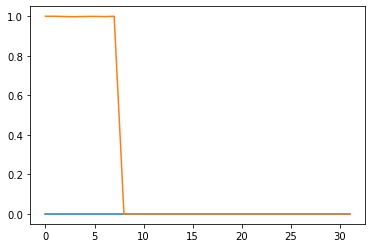

In [109]:
plt.plot(labels[1].detach().numpy())
plt.plot(output[1].detach().numpy())

In [28]:
val_h = model.init_hidden(batch_size)
val_losses = []
val_outputs = []
model.eval()
for val_inputs, val_labels in val_loader:
    val_h = tuple([each.data for each in val_h])
    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

    val_out, val_h = model(val_inputs, val_h)
    val_loss = loss_function(val_out.squeeze(), val_labels.float())
    val_losses.append(val_loss.item())
    val_outputs += [val_out.clone().detach()]

model.train()

LSTM(
  (lstm): LSTM(32, 2, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=2, out_features=32, bias=True)
  (activation): Sigmoid()
)

In [29]:
val_outputs_one = torch.cat(val_outputs, 0)

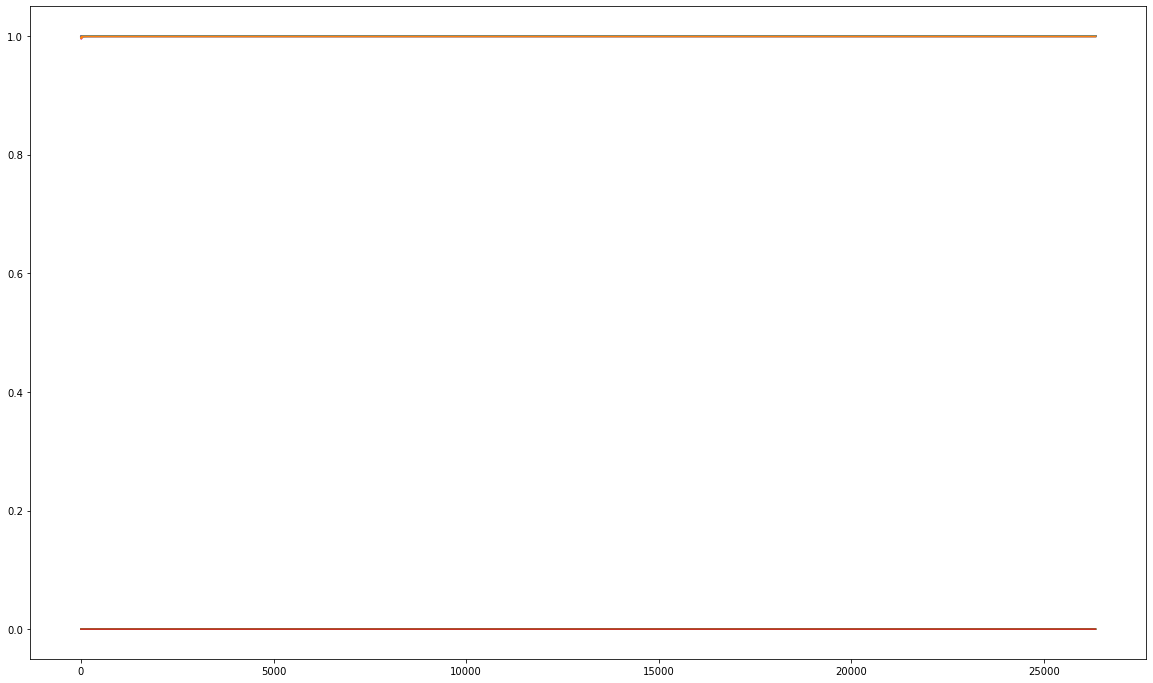

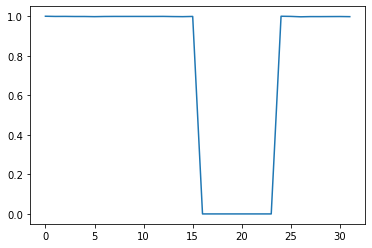

In [65]:
plt.figure(figsize=(20, 12))
plt.plot(val_outputs_one)
plt.show()
plt.plot(val_outputs_one[0])
plt.show()

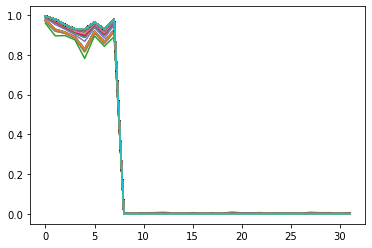

In [102]:
for i in range(1000):
    plt.plot(val_outputs_one[i])

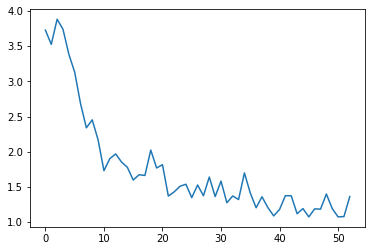

In [103]:
plt.plot(loss_list[::100])
plt.savefig('right_loss3.png', dpi=500, facecolor='w')

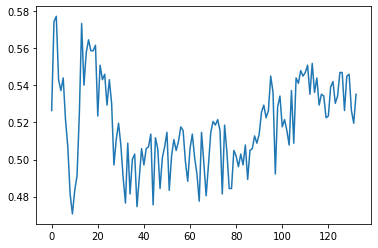

In [33]:
plt.plot(acc_list[::100])

In [34]:
loss_function.counter_one, loss_function.counter_zero

AttributeError: 'CustomLoss' object has no attribute 'counter_one'

In [ ]:
list(train_loader)[0][0].size(0) * len(train_loader)

## Baseline